In [2]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm
from sklearn.cluster import MeanShift
from sklearn.metrics.cluster import rand_score

# Mean Shift Clustering

In [ ]:
results = []

# load y labels
y = pd.read_feather(f'./data/mnist_subset_labels.feather').squeeze()

for i in tqdm(range(2, 201, 10), desc='PCA', unit='dim'):
    # load PCA model and fit msm
    X = pd.read_feather(f'./data/pca/mnist_pca_{i}.feather')

    out = {
        'PCA': i,
        'results': [],
    }

    for bandwidth in tqdm([0.1, 0.5, 1, 2, 3, 4, 5, 6], desc='Bandwidth', unit='bw'):
        hyper_params = {
            'bandwidth': bandwidth,
            'n_jobs': -1,
            'max_iter': 300,
        }
    
        msm = MeanShift(**hyper_params)

        start = time.time()
        msm.fit(X)
        elapsed = time.time() - start

        start = time.time()
        clusters = msm.predict(X)
        elapsed_pred = time.time() - start

        score = rand_score(y, clusters)

        out['results'].append({msm_results
            'bandwidth': msm.bandwidth,
            'n_clusters': len(np.unique(clusters)),
            'score': score,
            'fit_time': elapsed,
            'predict_time': elapsed_pred,
        })

    results.append(out)

In [9]:
pd.DataFrame(results).to_feather('./results/msm_results.feather')

# Results
The results are saved in a feather file. We can load them and make some statistics.

In [3]:
results = pd.read_feather('./results/msm_results.feather')

## Best results
We can find the best results for each PCA dimension.

In [4]:
best_results = []
for i in range(len(results)):
    best = max(results.iloc[i]['results'], key=lambda x: x['score'])
    best_results.append({
        'PCA': results.iloc[i]['PCA'],
        'bandwidth': best['bandwidth'],
        'n_clusters': best['n_clusters'],
        'score': best['score'],
        'fit_time': best['fit_time'],
        'predict_time': best['predict_time'],
    })

best_results = pd.DataFrame(best_results)
best_results

,PCA,bandwidth,n_clusters,score,fit_time,predict_time
0,2,0.1,3077,0.899633,85.289198,2.703851
1,12,2.0,6370,0.903977,296.984033,5.217837
2,22,3.0,4552,0.905631,763.364621,3.950438
3,32,4.0,1475,0.904376,961.140019,1.374306
4,42,4.0,3793,0.907117,1291.102779,3.475688
5,52,4.0,6481,0.906542,1324.836578,3.838357
6,62,4.0,9209,0.905987,1745.046934,5.328928
7,72,4.0,11759,0.905586,1557.784941,7.315098
8,82,4.0,13943,0.905105,1397.667253,8.689452
9,92,5.0,3229,0.905372,2493.033968,3.952580


## Best result overall

In [5]:
best_results.iloc[best_results['score'].idxmax()]

PCA               42.000000
bandwidth          4.000000
n_clusters      3793.000000
score              0.907117
fit_time        1291.102779
predict_time       3.475688
Name: 4, dtype: float64

## Plots
Make a plot of the score in relation to the PCA dimension and one for the bandwidth in relation to the PCA dimension.

Text(0.5, 1.0, 'Bandwidth in relation to PCA dimension')

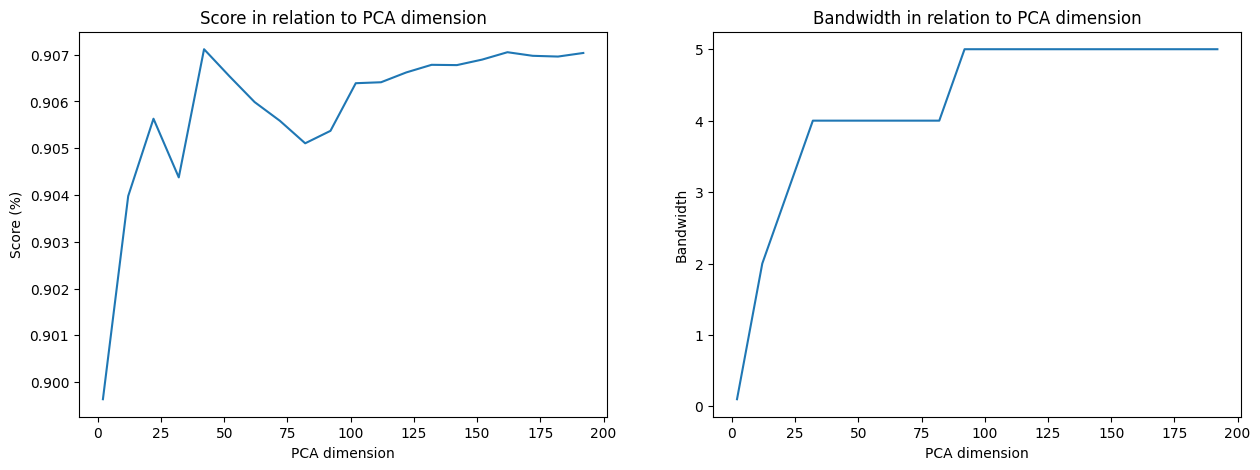

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(best_results['PCA'], best_results['score'])
ax[0].set_xlabel('PCA dimension')
ax[0].set_ylabel('Score (%)')
ax[0].set_title('Score in relation to PCA dimension')

ax[1].plot(best_results['PCA'], best_results['bandwidth'])
ax[1].set_ylabel('Bandwidth')
ax[1].set_xlabel('PCA dimension')
ax[1].set_title('Bandwidth in relation to PCA dimension')

Plot the fitting and prediction time in relation to the PCA dimension.

Text(0.5, 1.0, 'Prediction time in relation to PCA dimension')

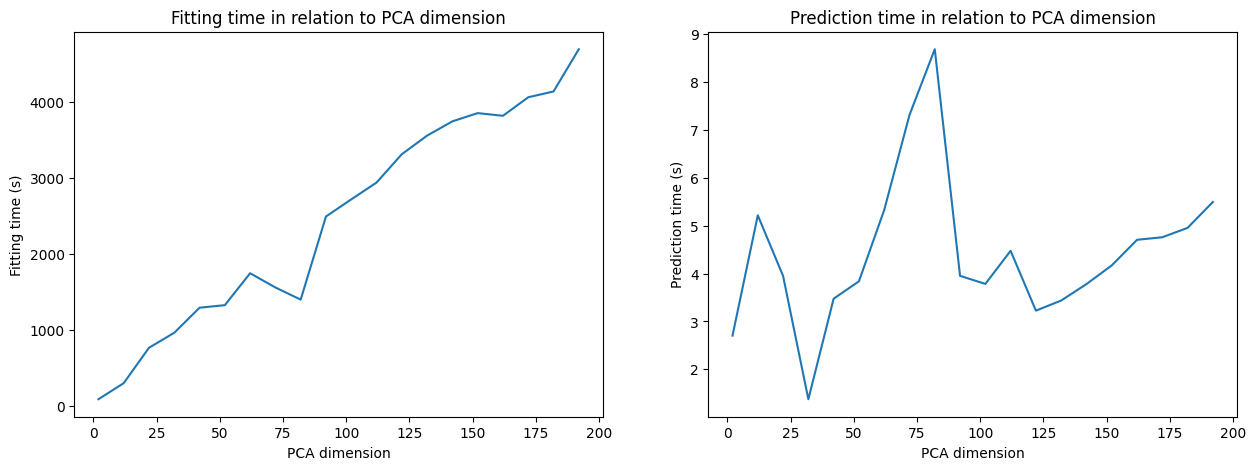

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(best_results['PCA'], best_results['fit_time'])
ax[0].set_xlabel('PCA dimension')
ax[0].set_ylabel('Fitting time (s)')
ax[0].set_title('Fitting time in relation to PCA dimension')

ax[1].plot(best_results['PCA'], best_results['predict_time'])
ax[1].set_xlabel('PCA dimension')
ax[1].set_ylabel('Prediction time (s)')
ax[1].set_title('Prediction time in relation to PCA dimension')

Plot number of clusters in relation to the PCA dimension.

Text(0.5, 1.0, 'Number of clusters in relation to PCA dimension')

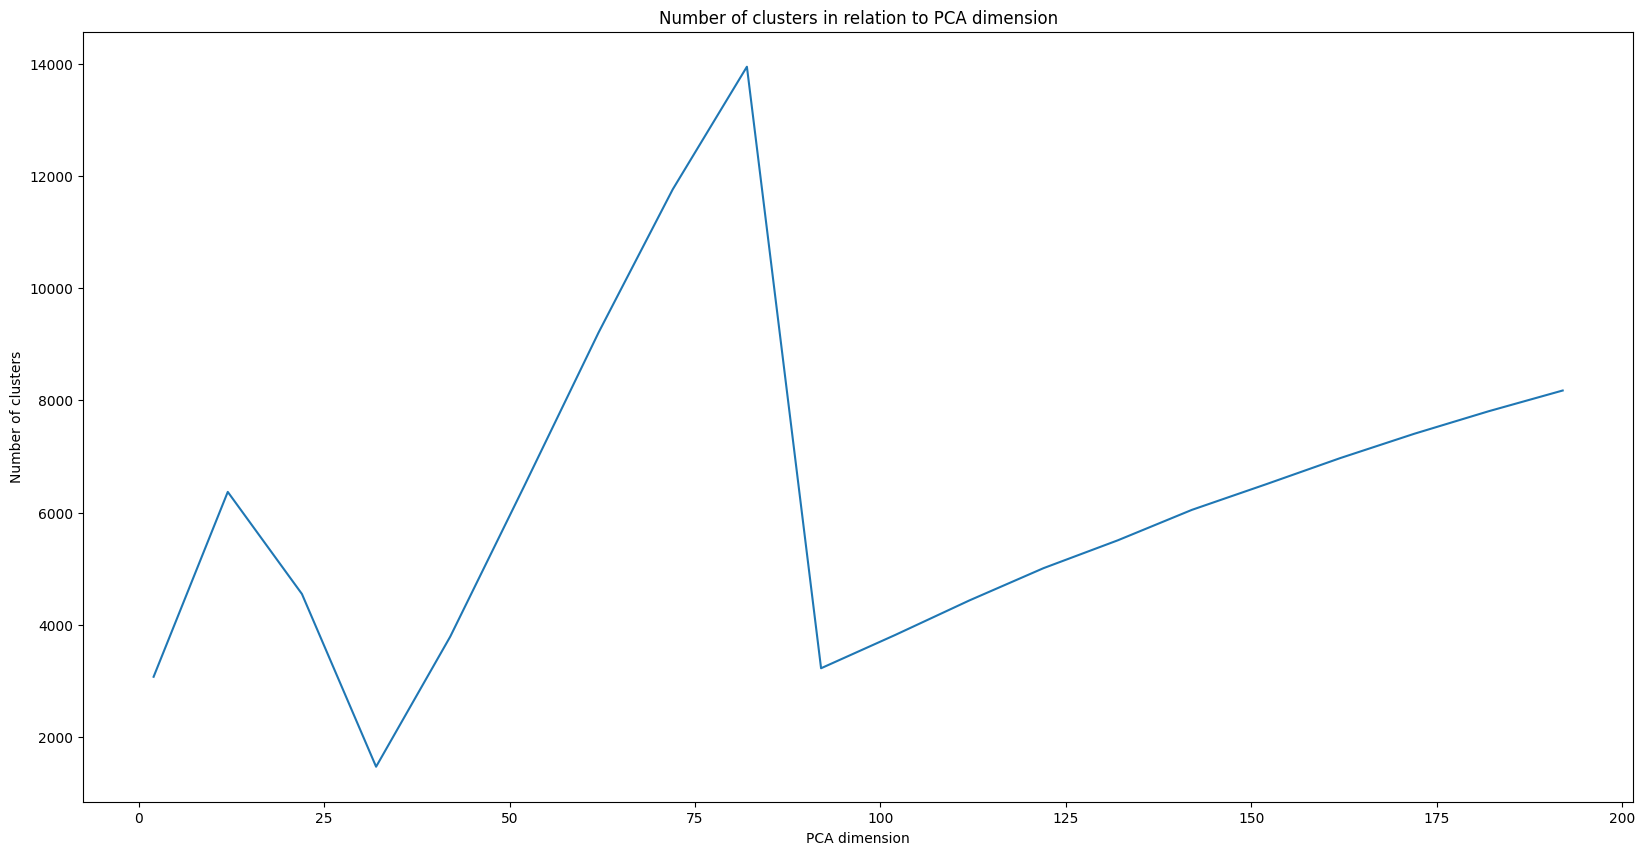

In [8]:
plt.figure(figsize=(20, 10))
plt.plot(best_results['PCA'], best_results['n_clusters'])
plt.xlabel('PCA dimension')
plt.ylabel('Number of clusters')
plt.title('Number of clusters in relation to PCA dimension')

Plotting cluster in 2 dimensions with Ellipses for the covariance.

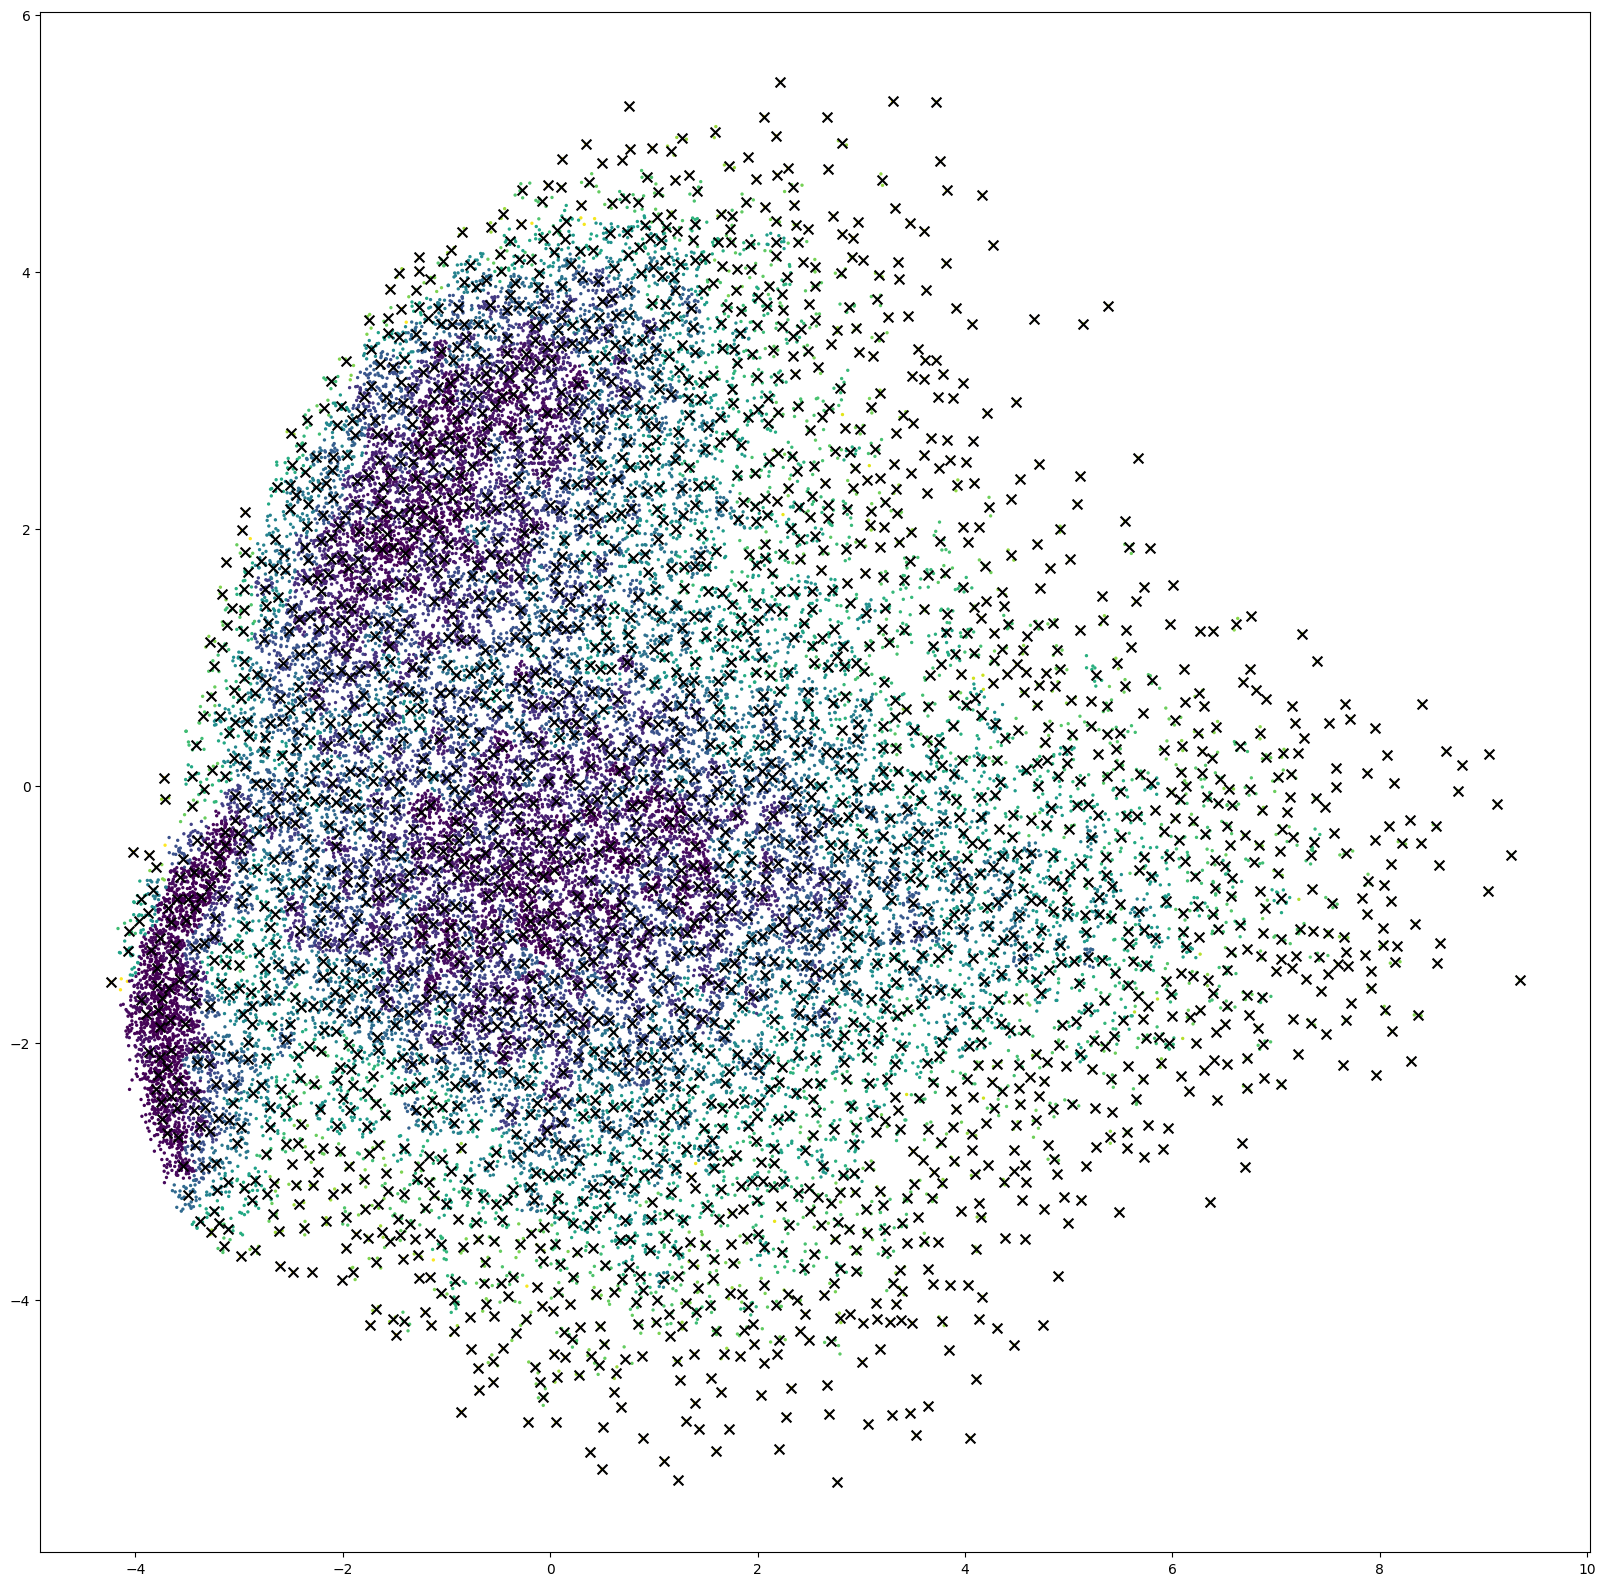

In [9]:
X = pd.read_feather('./data/pca/mnist_pca_2.feather')
# best result for PCA 2
best_res = best_results.iloc[0]
msm = MeanShift(bandwidth=best_res['bandwidth'], n_jobs=-1, max_iter=300)
labels = msm.fit_predict(X)

plt.figure(figsize=(20,20))
ax = plt.gca()
ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=labels, s=2, cmap=plt.get_cmap('viridis'), zorder=2, alpha=1)

# draw cluster centers
cluster_centers = msm.cluster_centers_
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=50, c='black', zorder=3, marker='x')